Regardless of our purpose, it can be helpful to use different visualizations of our model's performance both to understand and appreciate what it is capable of learning and expressing. So far we have visualized loss using plots and tensorboard, learning via data fitting and synthetic image generation, and convolutional and weight layers by displaying their values and responses to input.

In this section, we'll add a few more visualization techniques to our bag of tricks. 

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as tfl
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import coins
from skimage.transform import resize
from scipy.misc import imresize, imsave
import matplotlib.animation as animation
import imageio as io
import os
import IPython.display as ipyd

/Users/jonathansherman/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# setup read/write

file_dir = os.getcwd()+"/imgs"
os.makedirs(file_dir, exist_ok=True)

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [ ]:
# Training Params
num_steps = 50000
batch_size = 128
learning_rate = 0.0004

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [ ]:
# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim]), name='weights_ghid'),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim]), name='weights_gout'),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim]), name='weights_dhid'),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1]), name='weights_dout'),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim]), name='bias_ghid'),
    'gen_out': tf.Variable(tf.zeros([image_dim]), name='bias_gout'),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim]), name='bias_dhid'),
    'disc_out': tf.Variable(tf.zeros([1]), name='bias_dout'),
}
    

In [ ]:
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)
print(gen_sample.get_shape())

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)
print(disc_real.get_shape(), disc_fake.get_shape())

# Build Loss (note that below reduces to a scalar from (1 x 128) vector, 128 being batch_size)
# Note we are also taking the inverse of the disc_fake loss for the gen_loss
# If we wish to perform loss by class, then we must rework some graph elements
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [ ]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

imgs = []

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        # Testing
        # Generate images from noise, using the generator network.
        n = 10
        canvas = np.empty((28 * n, 28 * n))
        for j in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate nx784 image from noise.
            g = sess.run(gen_sample, feed_dict={gen_input: z})
            # Reverse colours for better display
            g = -1 * (g)
            for k in range(n):
                # Draw the generated digits
                canvas[j * 28:(j + 1) * 28, k * 28:(k + 1) * 28] = g[k].reshape([28, 28])

        #gif builder wants a list
        #imgs.append(canvas)
        #print(imgs)
        canvas_resize = imresize(canvas,(580,580))
        io.imwrite(file_dir+'/gan_MNIST%d.png' % (i), canvas_resize)
        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()
#build_gif(imgs, cmap='gray', dpi=36, saveto='gan_MNIST.gif')

In [ ]:
images = []
for file_name in os.listdir(file_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(file_dir, file_name)
        images.append(io.imread(file_path))
        print(np.asarray(images).shape)
io.mimsave(file_dir+'/gan_MNIST.gif', images)

ipyd.Image(url='gan_MNIST.gif',
           height=500, width=500)

In [ ]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

imgs = []

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        # Testing
        # Generate images from noise, using the generator network.
        n = 10
        canvas = np.empty((28 * n, 28 * n))
        for j in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate nx784 image from noise.
            g = sess.run(gen_sample, feed_dict={gen_input: z})
            # Reverse colours for better display
            if j%2 == 0:
                g = -1 * (g)
            for k in range(n):
                # Draw the generated digits
                canvas[j * 28:(j + 1) * 28, k * 28:(k + 1) * 28] = g[k].reshape([28, 28])

        canvas_resize = imresize(canvas,(580,580))
        io.imwrite(file_dir+'/gan_MNIST%d.png' % (i), canvas_resize)
        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()
#build_gif(imgs, cmap='gray', dpi=36, saveto='gan_MNIST.gif')

In [ ]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

imgs = []

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        # Testing
        # Generate images from noise, using the generator network.
        n = 10
        canvas = np.empty((28 * n, 28 * n))
        for j in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate nx784 image from noise.
            g = sess.run(gen_sample, feed_dict={gen_input: z})
            mask = (abs(g) < np.percentile(abs(g), 90))
            g = g * np.clip(g - mask, 0, 1)
            # Reverse colours for better display
            g = -1 * (g)
            for k in range(n):
                if np.random.randint(2) == 0:
                    g = -1 * (g)
                # Draw the generated digits
                canvas[j * 28:(j + 1) * 28, k * 28:(k + 1) * 28] = g[k].reshape([28, 28])

        #gif builder wants a list
        #imgs.append(canvas)
        #print(imgs)
        canvas_resize = imresize(canvas,(580,580))
        io.imwrite(file_dir+'/gan_MNIST%d.png' % (i), canvas_resize)
        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()
#build_gif(imgs, cmap='gray', dpi=36, saveto='gan_MNIST.gif')

In [ ]:
a = np.array(np.linspace(0.5,1,20))
mask = (abs(a) < np.percentile(abs(a), 90))
print(a,'\n',a*np.clip(a-mask, 0, 1))

In [ ]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

imgs = []

z_const = np.random.uniform(-1., 1., size=[n, noise_dim])

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        # Testing
        # Generate images from noise, using the generator network.
        n = 10
        canvas = np.empty((28 * n, 28 * n))
        for j in range(n):
            # Noise input.
            #z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate nx784 image from noise.
            g = sess.run(gen_sample, feed_dict={gen_input: z_const})
            for k in range(n):
                if i == 1:
                    g = np.zeros(g.shape)+0.5
                else:
                    g = g*0.9
                # Draw the generated digits
                canvas[j * 28:(j + 1) * 28, k * 28:(k + 1) * 28] = g[k].reshape([28, 28])

        canvas_resize = imresize(canvas,(580,580))
        io.imwrite(file_dir+'/gan_MNIST%d.png' % (i), canvas_resize)
        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="Pastel1")
        plt.show()


In [90]:
#sess.close()
tf.reset_default_graph()

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


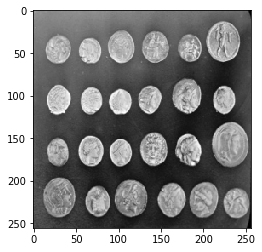

In [91]:
from skimage.data import coins
img = imresize(coins(), (256, 256))
plt.imshow(img, cmap='gray')
plt.show()

In [92]:
# We'll first collect all the positions in the image in our list, xs# We'll  
xs = []

# And the corresponding colors for each of these positions
ys = []

# Now loop over the image
for row_i in range(img.shape[0]):
    for col_i in range(img.shape[1]):
        # And store the inputs
        xs.append([row_i, col_i])
        # And outputs that the network needs to learn to predict
        ys.append(img[row_i, col_i])

# we'll convert our lists to arrays
xs = np.array(xs)
ys = np.array(ys)

# add dim for ys (so tf treats it as matrix)

ys = np.expand_dims(ys, axis=1)

# Normalizing the input by the mean and standard deviation
xs = (xs - np.mean(xs)) / np.std(xs)

# and print the shapes
xs.shape, ys.shape

((65536, 2), (65536, 1))

In [93]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 1], name='Y')


n_neurons  = [2, 256, 256, 256, 256, 1]

current_input = X
for layer_i in range(1, len(n_neurons)):
    current_input = tfl.linear(
        inputs=current_input,
        num_outputs=n_neurons[layer_i],
        activation_fn=tf.nn.tanh if (layer_i+1) < len(n_neurons) else tf.nn.relu,
        scope='layer/' + str(layer_i))
Y_pred = current_input

cost = tf.reduce_mean(
    tf.reduce_sum(tf.abs(Y_pred - Y), 1))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [94]:
graph = tf.get_default_graph()
[op.values() for op in graph.get_operations()]

[(<tf.Tensor 'X:0' shape=(?, 2) dtype=float32>,),
 (<tf.Tensor 'Y:0' shape=(?, 1) dtype=float32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform/shape:0' shape=(2,) dtype=int32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform/min:0' shape=() dtype=float32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform/max:0' shape=() dtype=float32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform/RandomUniform:0' shape=(2, 256) dtype=float32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform/sub:0' shape=() dtype=float32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform/mul:0' shape=(2, 256) dtype=float32>,),
 (<tf.Tensor 'layer/1/weights/Initializer/random_uniform:0' shape=(2, 256) dtype=float32>,),
 (<tf.Tensor 'layer/1/weights:0' shape=(2, 256) dtype=float32_ref>,),
 (<tf.Tensor 'layer/1/weights/Assign:0' shape=(2, 256) dtype=float32_ref>,),
 (<tf.Tensor 'layer/1/weights/read:0' shape=(2, 256) dtype=float32>,),
 (<tf.Tensor 'layer

In [95]:
feature = tf.get_default_graph().get_tensor_by_name('layer/4/Tanh:0')
gradient = tf.gradients(tf.reduce_max(feature, 1), X)

(65536, 2)


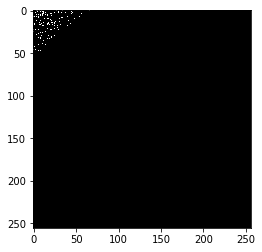

(65536, 2)


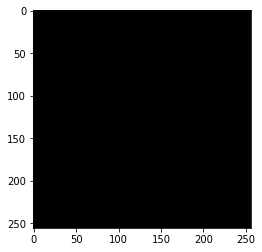

(65536, 2)


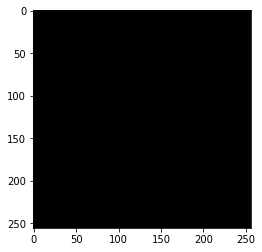

(65536, 2)


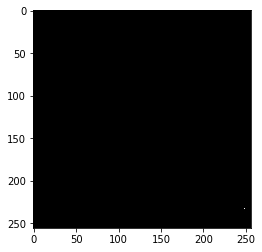

(65536, 2)


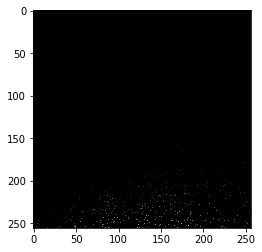

(65536, 2)


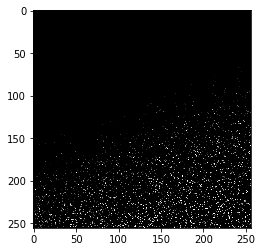

(65536, 2)


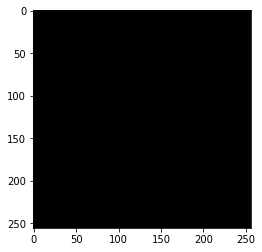

(65536, 2)


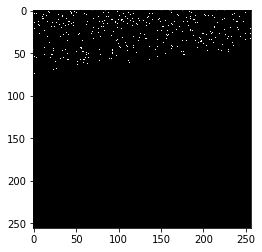

(65536, 2)


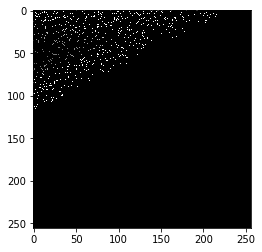

(65536, 2)


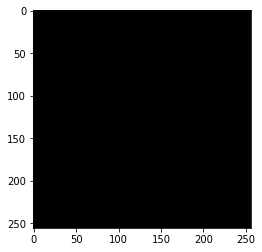

(65536, 2)


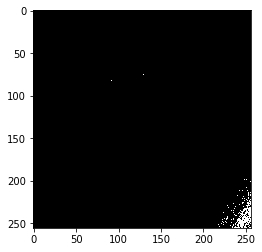

(65536, 2)


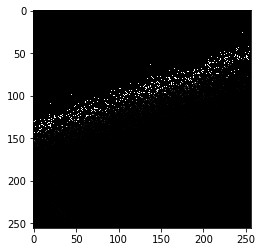

(65536, 2)


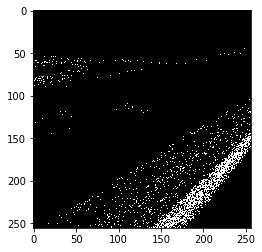

(65536, 2)


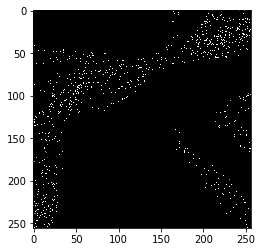

(65536, 2)


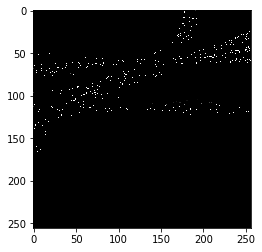

(65536, 2)


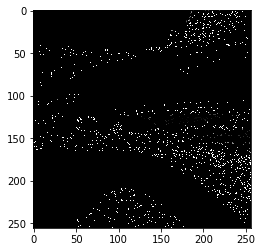

(65536, 2)


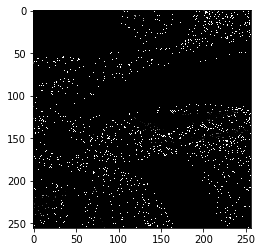

(65536, 2)


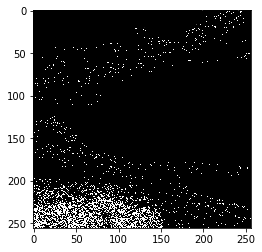

KeyboardInterrupt: 

In [87]:
n_iterations = 1000
batch_size = 50
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(tf.global_variables_initializer())

    # We now run a loop over epochs
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
            

        #training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        #print(it_i, training_cost)

        grad = sess.run(gradient[0], feed_dict={X: xs})
        #try np.max for relu
        print(grad.shape)
        grad /= (np.min(np.abs(grad)) + 1e-8)
        grad_fit = np.asarray(grad[:, 0])
        grad_fit.shape = (256, 256)
        # try 0-1 for relu
        grad_fit += grad_fit*255
        grad_fit = np.clip(grad_fit, 0, 255).astype(np.uint8)
        fig, ax = plt.subplots(1, 1)
        plt.imshow(grad_fit, cmap='gray')
        plt.show()

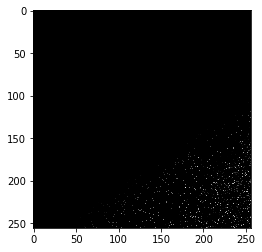

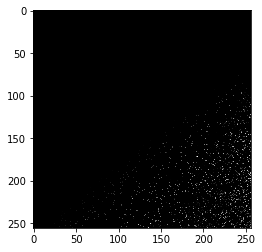

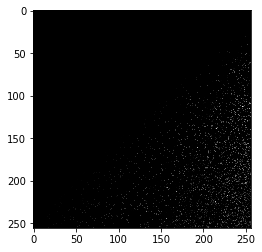

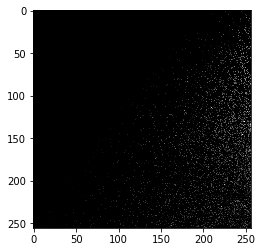

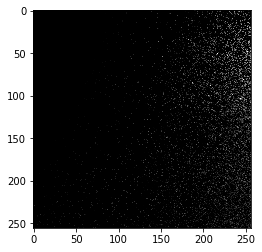

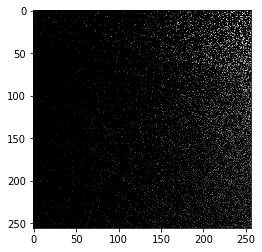

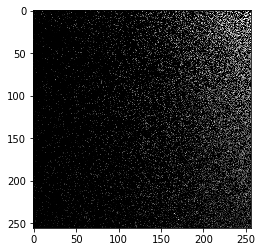

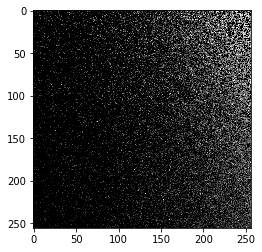

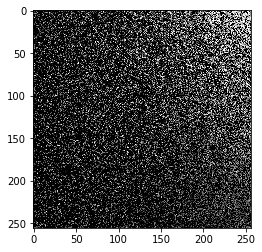

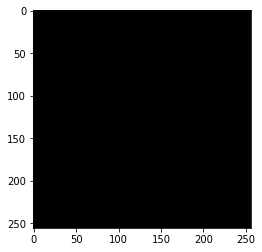

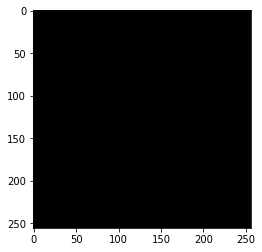

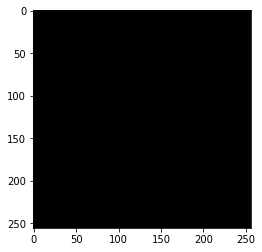

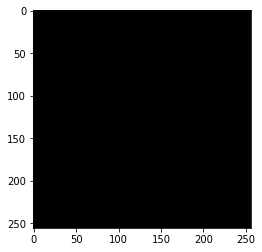

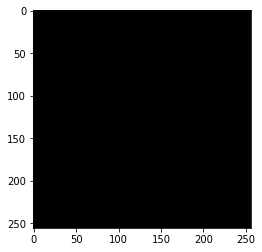

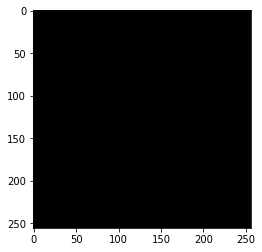

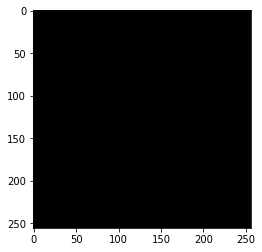

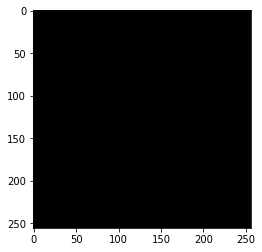

KeyboardInterrupt: 

In [88]:
n_iterations = 1000
batch_size = 50
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(tf.global_variables_initializer())

    # We now run a loop over epochs
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
            

        #training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        #print(it_i, training_cost)

        grad = sess.run(gradient[0], feed_dict={X: xs})
        grad /= (np.min(np.abs(grad)) + 1e-8)
        grad_fit = np.asarray(grad[:, 1])
        grad_fit.shape = (256, 256)
        grad_fit += grad_fit*255*1.2
        grad_fit = np.clip(grad_fit, 0, 255).astype(np.uint8)
        fig, ax = plt.subplots(1, 1)
        plt.imshow(grad_fit, cmap='gray')
        plt.show()

(254, 254)


/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


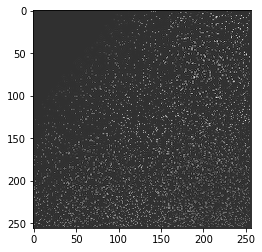

(254, 254)


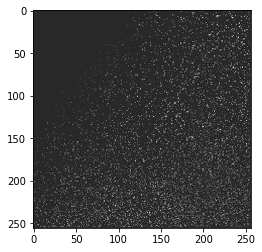

(254, 254)


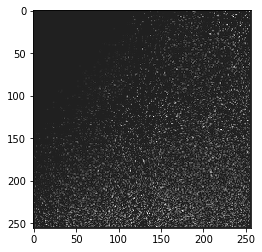

(254, 254)


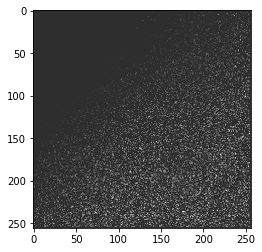

(254, 254)


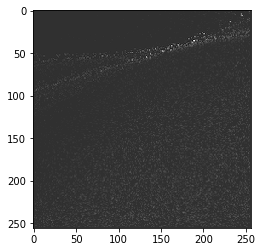

(254, 254)


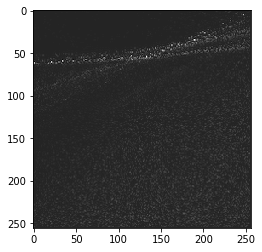

(254, 254)


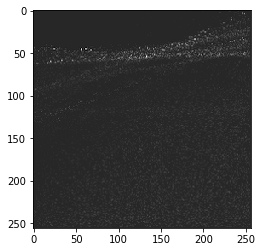

(254, 254)


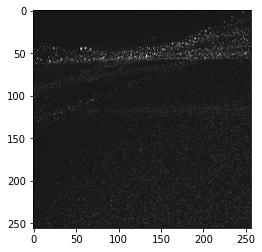

(254, 254)


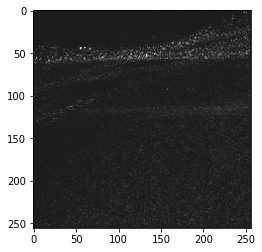

(254, 254)


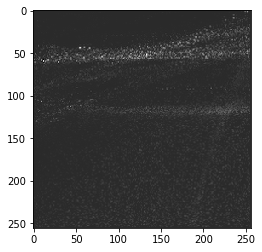

(254, 254)


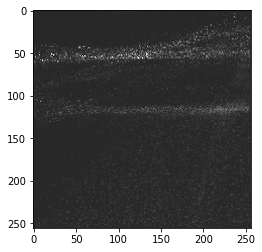

(254, 254)


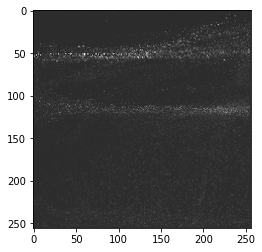

(254, 254)


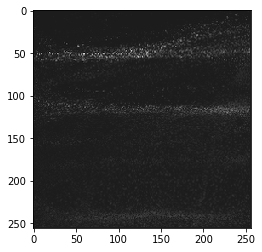

(254, 254)


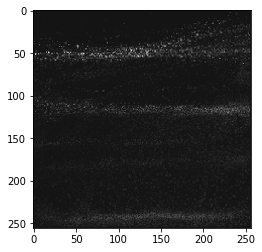

(254, 254)


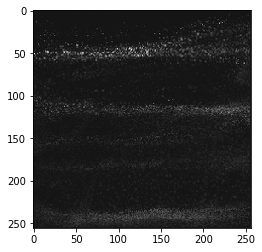

(254, 254)


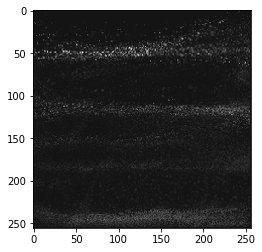

(254, 254)


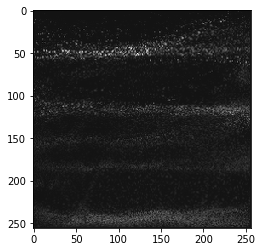

(254, 254)


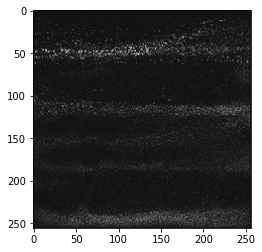

(254, 254)


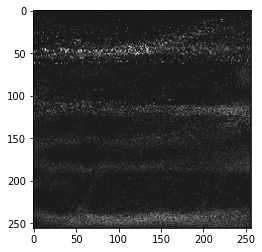

(254, 254)


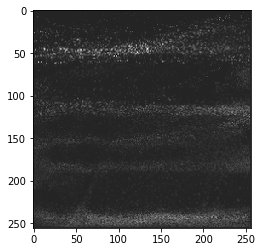

(254, 254)


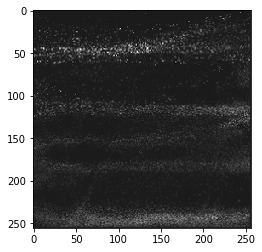

(254, 254)


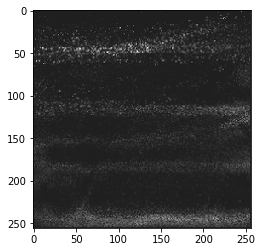

(254, 254)


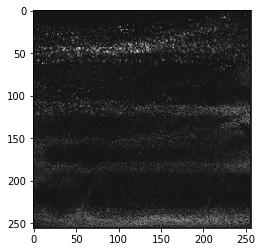

(254, 254)


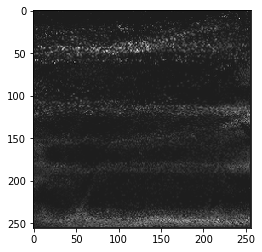

(254, 254)


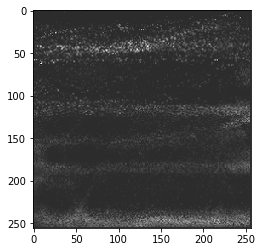

(254, 254)


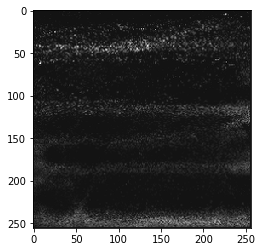

(254, 254)


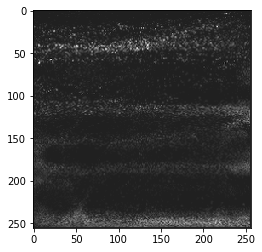

(254, 254)


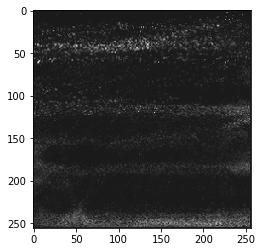

(254, 254)


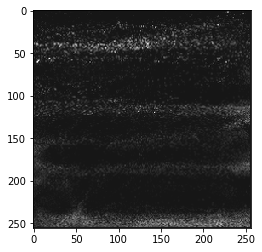

KeyboardInterrupt: 

In [96]:
crop = 1
n_iterations = 1000
batch_size = 50
img_c = np.zeros([256,256])
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(tf.global_variables_initializer())

    # We now run a loop over epochs
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
            

        #training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        #print(it_i, training_cost)

        grad = sess.run(gradient[0], feed_dict={X: xs})
        grad /= (np.max(np.abs(grad)) + 1e-8)
        grad_fit = np.asarray(grad[:, 0])
        grad_fit.shape = (256, 256)
        img_c += grad_fit*255*1.2
        img_c = np.clip(img_c, 0, 255).astype(np.uint8)
        img_c = img_c[crop:-crop, crop:-crop]
        print(img_c.shape)
        img_c = resize(img_c, (256, 256), order=4,
             clip=False, preserve_range=True)#[np.newaxis].astype(np.float32)
        fig, ax = plt.subplots(1, 1)
        plt.imshow(img_c, cmap='gray')
        plt.show()

(254, 254)


/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


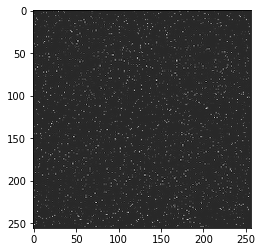

(254, 254)


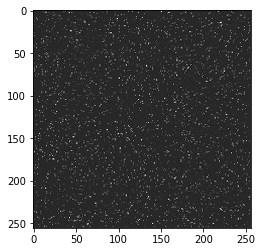

(254, 254)


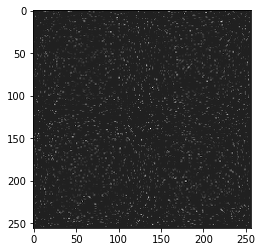

(254, 254)


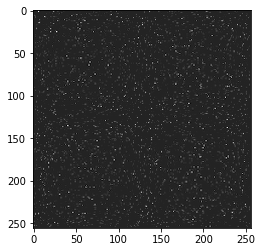

(254, 254)


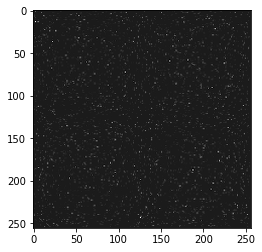

(254, 254)


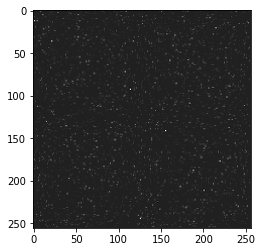

(254, 254)


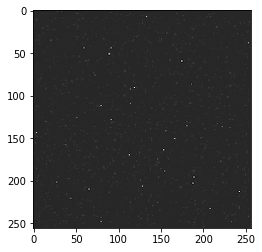

(254, 254)


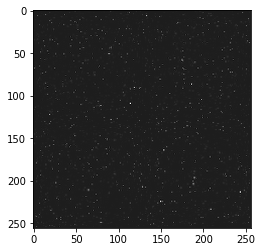

KeyboardInterrupt: 

In [97]:
crop = 1
n_iterations = 1000
batch_size = 50
img_noise = np.clip(0.1*np.random.randn(65536,2)*255, 0, 255)
img_c = np.zeros([256,256])
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(tf.global_variables_initializer())

    # We now run a loop over epochs
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
            

        #training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        #print(it_i, training_cost)

        grad = sess.run(gradient[0], feed_dict={X: img_noise})
        grad /= (np.max(np.abs(grad)) + 1e-8)
        grad_fit = np.asarray(grad[:, 0])
        grad_fit.shape = (256, 256)
        img_c += grad_fit*255*1.2
        img_c = np.clip(img_c, 0, 255).astype(np.uint8)
        img_c = img_c[crop:-crop, crop:-crop]
        print(img_c.shape)
        img_c = resize(img_c, (256, 256), order=4,
             clip=False, preserve_range=True)#[np.newaxis].astype(np.float32)
        fig, ax = plt.subplots(1, 1)
        plt.imshow(img_c, cmap='gray')
        plt.show()

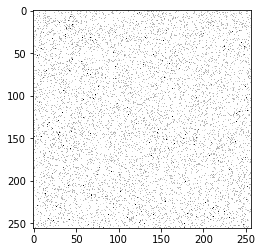

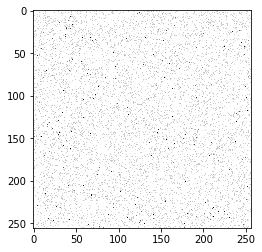

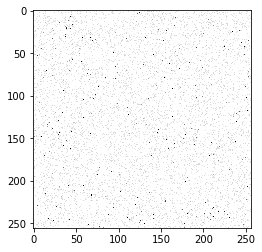

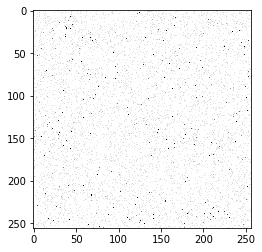

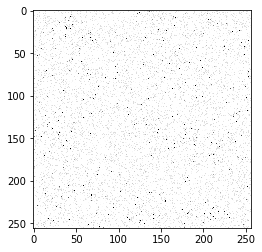

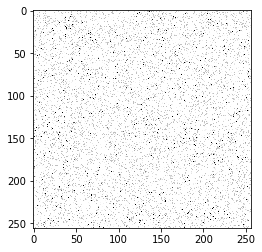

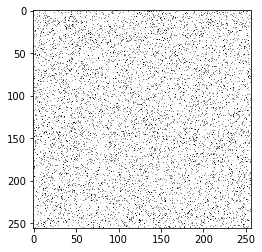

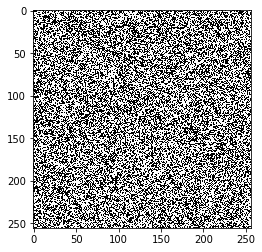

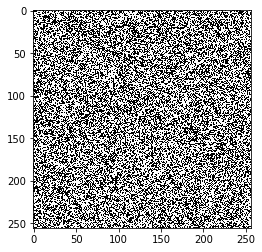

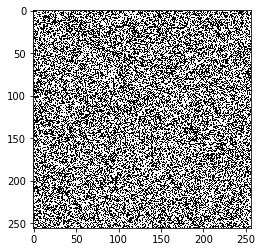

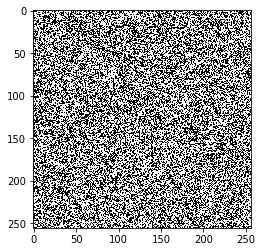

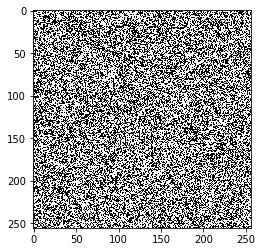

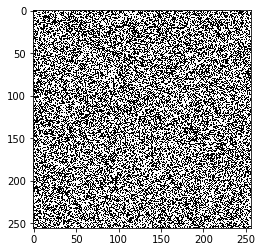

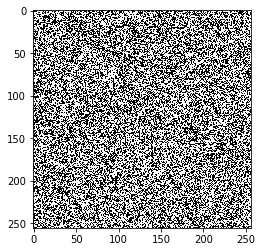

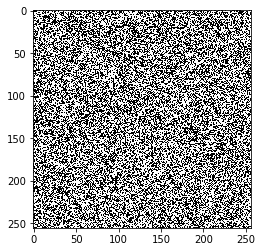

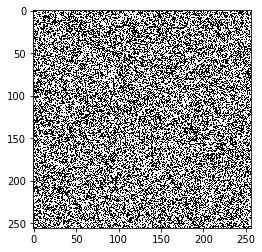

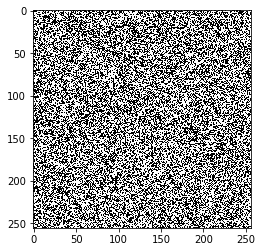

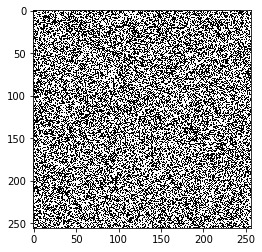

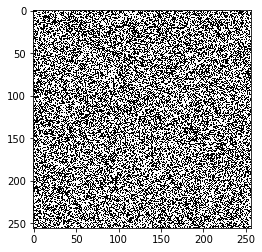

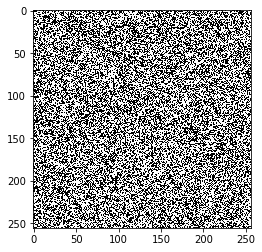

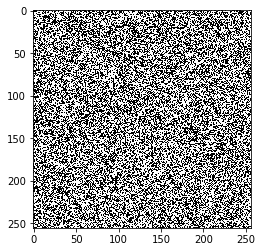

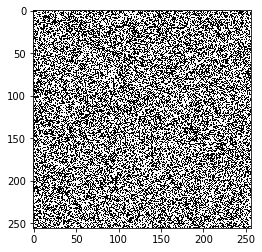

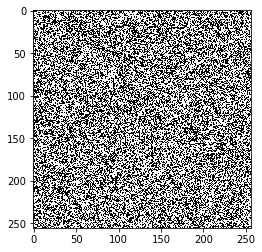

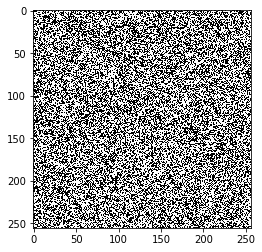

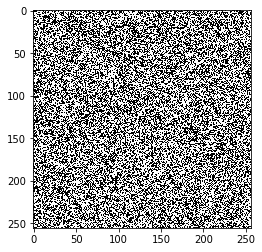

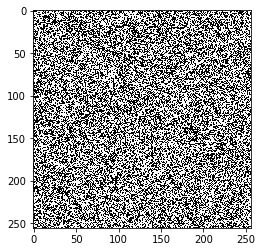

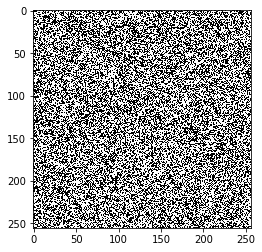

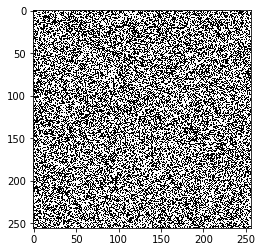

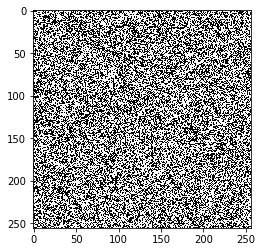

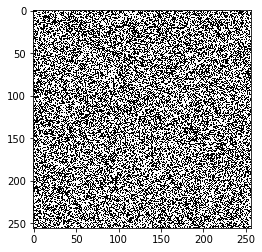

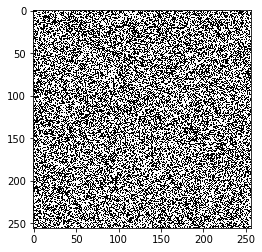

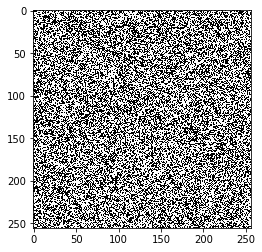

KeyboardInterrupt: 

In [99]:
img_noise = np.clip(0.1*np.random.randn(65536,2)*255, 0, 255)
n_iterations = 500
batch_size = 50
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(tf.global_variables_initializer())

    # We now run a loop over epochs
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})

        #training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        #print(it_i, training_cost)

        
        ys_pred = Y_pred.eval(feed_dict={X: img_noise}, session=sess)
        fig, ax = plt.subplots(1, 1)
        img = np.clip(ys_pred.reshape(img.shape), 0, 255).astype(np.uint8)
        plt.imshow(img, cmap='gray')
        plt.show()